# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Image Classificatoin using Convolution Neural Network 

In this project, I have picked up a problem in the domain of Computer Vision - *Classify RGB images in CIFAR-10 dataset into 10 classes*. I am up taking this problem of building a CIFAR-10 Classifier with Convolution Neural Network using neural network framework with the following motivation:

1. Learn the nuances of Convolution Neural Network.
2. Compare different neural network framework for quick development. 
3. Learn this framework.
4. Solve a problem in Computer Vision domain using the above framework.

I have an ultimate goal to build my own prototype of self-driving car and I belive the above goals lay down a good foundation for this ultimate goal. 

-----

## Getting Started
In this project, I am trying to solve the problem of Images classification of CIFAR-10 dataset using a modified AlexNet Architecture. We will explore the data and then build the AlexNet architecture using the TensorFlow framework.

### Data Set


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import cifar10
import numpy as np
cifar10.data_path = "./data/"
cifar10.maybe_download_and_extract()
class_names = cifar10.load_class_names()
print(class_names)

Data has apparently already been downloaded and unpacked.
Loading data: ./data/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Loading the training set. This returns the images, the class-numers as integers and the class-numers as One-Hot encoded arrays called labels.

In [2]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: ./data/cifar-10-batches-py/data_batch_1
Loading data: ./data/cifar-10-batches-py/data_batch_2
Loading data: ./data/cifar-10-batches-py/data_batch_3
Loading data: ./data/cifar-10-batches-py/data_batch_4
Loading data: ./data/cifar-10-batches-py/data_batch_5


Loading the test set. Similar to training set, it returns images, class number and one hot encoding as labels.

In [3]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: ./data/cifar-10-batches-py/test_batch


Now that both training and testing data has been loaded, we find out the number of samples in each of these data sets.

In [4]:
print("Size of:")
print("- Training Set:\t\t{}".format(len(images_train)))
print("- Testing Set:\t\t{}".format(len(images_test)))

Size of:
- Training Set:		50000
- Testing Set:		10000


#### Data Dimensions

Now we look at the dimensions of the data set. The given dataset has 5000 images per class. To increase the number of trainig set, we randomly crop the training input image to 24x24 and do other pre-processing like - flipping, rotating, changing the contrast etc. 

In [5]:
from cifar10 import img_size, num_channels, num_classes
img_size_cropped = 24

#### Plotting the images

We analyze few of the images from the data set. The image are not in the standard format so we write a helper function here to load and plot the image.

In [6]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    
    #Create a figure with sub-plots
    fig, axes = plt.subplots(3, 3)
    
    #Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
        
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
            
        ax.imshow(images[i, :, :, :],
                 interpolation = interpolation)
        
        #Name of the true class
        cls_true_name = class_names[cls_true[i]]
        
        #Show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            #Name of the predicted class
            cls_pred_name = class_names[cls_pred[i]]
            
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            
        #Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        #Remote ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    #Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#### Plotting few images

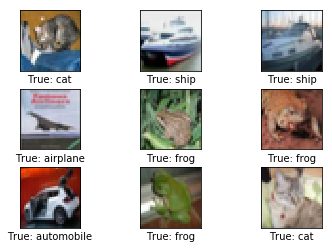

In [7]:
# Get the first 9 images from the test-set
images = images_test[0:9]

#Get the true classes for those images
cls_true = cls_test[0:9]

#Plot the images and labels using the function defined above
plot_images(images=images, cls_true=cls_true, smooth=False)

The images plotted above are pixelated that the neural network will get. 

### Neural Network Framework

There are many open source Neural Network framework available. Also, there have been detailed comparative analysis of each of these frameworks. We have used the analysis of these studies to pick Tensorflow as our framework tool for following two reasons:

1. It has better support for GPUs and multi-GPUs.
2. It's popularity in the industry and more flexibility in tuning different parameters of a network.

The entire purpose of TensorFlow is to have a so-called computational grpah that can be executed much more efficiently that if the same calculations were to be performed directly in Python. TensorFlow can be more efficient that NumPy because TF knows the entire computation graph that must be executed, while NumPy only know the computation of a single mathematical operation at a time. 

TF can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model better. This is because the graphi is a combination of simple mathematical expressions so that gradient of the entire graph can be calculated using the chain-rule for derivatives. 

A TF graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolution network perform better.
* The mathematical formulas for the convolution network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

#### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below:

First, we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to *float32* and the shape is set to [None, img_size, img_size, num_channels], where None means that the tensor may hold an arbitrary number of images with each image being img_size pixels high and img_size pixels wide and with num_channels colour channels.


In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

Next, we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [9]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TF operator so nothing is calculated at this point. 

In [10]:
y_true_cls = tf.argmax(y_true, axis=1)

#### Pre-processing the Input

We create a function that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TF. 

The pre-processing is different for training and testing of the neural network:
* For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturations is adjusted with random variables. This artificially inflates the size of the trainig set by creating random variations of the original input images. Examples of distorted images are shown below.
* For testing, the input images are cropped around the centre and nothing else is adjusted.

In [11]:
def pre_process_image(image, training):
    if training:
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        
        image = tf.image.random_flip_left_right(image)
        
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        
        #Make sure the pixel values are between [0, 1]
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                      target_height=img_size_cropped,
                                                      target_width=img_size_cropped)
        
    return image

The function above is called for each image in the input batch using the following function.

In [12]:
def pre_process(images, training):
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    
    return images

In order to plot the distorted images, we create the pre-processing graph for TF, so we may execute it later.

In [13]:
#distorted_images = pre_process(images=x, training=True)

#### Helper function for Main Network

The following helper-function creates the main part of the CNN.

In [14]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer
        
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
        
        return y_pred, loss

#### Helper function for Neural Network
In this section, we tie up the pre-processing and the main-processing defined above.

Note that the neural network is enclosed in the variable-scope names 'network'. 

In [15]:
def create_network(training):
    with tf.variable_scope('network', reuse=not training):
        images = x
        images = pre_process(images=images, training=training)
        
        y_pred, loss = main_network(images=images, training=training)
        
    return y_pred, loss

#### Neural network for Training Phase

First we create a TF variable that keeps track of the number of optimization iterations performed so far. 

Note that trainable=False which means that TF will not try to optimize this variable.

In [16]:
global_step = tf.Variable(initial_value=0,
                         name='global_step', trainable=False)

Create the neural network to be used for training. The create_network() function returns both y_pred and loss, but we only need loss-function during training. 

In [17]:
_, loss = create_network(training=True)

Create an optimizer which will minimize the loss function. Also pass the global_setp variable to optimizer so it will be increased by one after each iteration.

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

#### Create Neural Network for Test Phase / Inference

Now create the nerural network for the test-phase. Once again the create_network() function returns the predicted class-labels y_pred for the input images, as well as the loss-function to be used during optimization. During testing we only need y_pred. 

In [19]:
y_pred, _ = create_network(training=False)

We then calculate the predicted class number as an integer. The output of the network y_pred is an array with 10 elements. The class number is the index of the largest element in the array. 

In [20]:
y_pred_cls = tf.argmax(y_pred, axis=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image. 

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Saver Object

In order to save the variables of the neural network, so they can be reloaded quickly without having to train the network again, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below:

In [23]:
saver = tf.train.Saver()

### Tensor Flow Session

#### Create TensorFlow session

Once the TF graph has been created, we have to create a TF session which is used to execute the graph.

In [24]:
session = tf.Session()

#### Restore or initialize variables

Training this neural network may take a long time, especially when we don't have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If we want to restart the training of the neural network, we have to delete the checkpoints first.

This is the directory used for the checkpoints

In [25]:
save_dir = 'checkpoints/'

Create the directory if it does not exist

In [26]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, TF will append the iteration number, etc.

In [27]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

First try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if you have changed the TF graph.

In [28]:
try:
    print("Trying to restor last checkpoint....")
    
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    
    saver.restore(session, save_path=last_chk_path)
    
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restor last checkpoint....
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-85000
Restored checkpoint from: checkpoints/cifar10_cnn-85000


#### Helper-function to get a random training batch

There are 50,000 images in the training-set. It takes a long time calculate the gradient of the model using all these images. I therefore only use a small batch of images in each iteration of the optimizer.

In [29]:
train_batch_size = 64
def random_batch():
    num_images = len(images_train)
    
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    
    return x_batch, y_batch

#### Helper-function to perform optimization

This function performs a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TF executes the optimizer using those training samples. The progress is printed every 100 iterations. A checkpoint is save every 10000 iterations and also after the last iteration. 

In [30]:
def optimize(num_iterations):
    start_time = time.time()
    
    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        i_global, _ = session.run([global_step, optimizer],
                                 feed_dict=feed_dict_train)
        
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session,
                      save_path=save_path,
                      global_step=global_step)
            print("Saved checkpoint")
            
        end_time = time.time()
        time_diff = end_time - start_time
        
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))

#### Helper-function to plot example errors

Function for plotting examples of images form the test-set that have been mis-classified.

In [31]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = images_test[incorrect]
    
    cls_pred = cls_pred[incorrect]
    cls_true = cls_test[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

#### Helper-function to plot confusion matrix

In [32]:
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred)
    
    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
        
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

#### Calculate Classification

Here we define a function to calculate the predicted classes of images and also return a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise.

In [33]:
batch_size = 256

def predict_cls(images, labels, cls_true):
    num_images = len(images)
    
    #Predicted values will be stored in this array
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    i = 0
    while i < num_images:
        #The ending index for the next batch is denoted by j
        j = min(i + batch_size, num_images)
        
        #Create a dict with the images & labels between i and j
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        #Set the start-index for the next batch to the end-index of the current batch
        i = j
        
    correct = (cls_true == cls_pred)
    
    return correct, cls_pred

Calculate the predicted class for the test-set

In [34]:
def predict_cls_test():
    return predict_cls(images=images_test,
                       labels=labels_test,
                       cls_true=cls_test)

#### Helper function for Evalution Metric

This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. The function also returns the number of correct classifictions.

In [35]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

#### Helper function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function

In [36]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    
    correct, cls_pred = predict_cls_test()
    
    acc, num_correct = classification_accuracy(correct)
    
    num_images = len(correct)
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

-----
## Performance Optimization

### Setup

My laptop computer is a Quad-core with 2.6 GHz per core. It has an Integrated GPU but not fast enough for TensorFlow so I only use CPU. It takes about 1 hour to perform 10,000 optimization iterations using the CPU on this PC. For this study, I performed 85,000 optimization iterations so that took about 9 hours. I let it run during the night and at various points during the day. 

In [37]:
if False:
    optimize(num_iterations=1000)

### Results

After 85,000 optimization iterations, the classification accuracy is about 79% on the test-set. Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for umans and others are reasonable mistakes e.g. between a cat and a dog.

Accuracy on Test-Set: 78.9% (7886 / 10000)
Example errors:


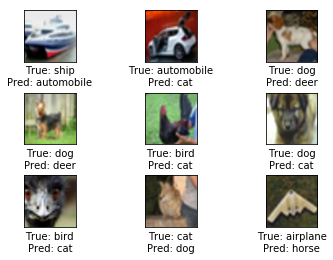

Confusion Matrix:
[814  17  38  14   5   5   9  18  39  41] (0) airplane
[  9 905   7   5   0   5   6   3  13  47] (1) automobile
[ 43   4 678  44  44  61  66  43  12   5] (2) bird
[ 22   7  41 562  47 188  65  33  14  21] (3) cat
[ 11   1  44  40 758  39  47  49   9   2] (4) deer
[  7   4  21 148  29 717  16  43   6   9] (5) dog
[  8   6  23  39  10  21 875  10   3   5] (6) frog
[  6   1  16  31  40  45   6 842   3  10] (7) horse
[ 48  21  13  10   2   5   4   4 862  31] (8) ship
[ 15  65   8   8   2   0   1   8  20 873] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [38]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.